In [1]:
!pip install statsmodels --quiet

## imports

In [2]:
import torch
import numpy as np
import networkx as nx
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.inter_rater import fleiss_kappa
from scipy.stats import pearsonr

# Correlation Analysis and Visualization

#### Data Loading

In [3]:
from google.colab import drive
drive.mount('/content/drive')

triples_df = pd.read_csv('/content/drive/MyDrive/My Research/triples_df.csv')
display(triples_df.head())

Mounted at /content/drive


,id,text_id,context,subject,relation,object,negated,dominant_distortion,secondary_distortion,relation_text,relation_cluster,relation_cluster_label,Dominant Distortion,Secondary Distortion (Optional)
0,0,1,Nobody likes me because I'm not interesting.,Nobody,like,me,False,General Distortion,NaN,like,1,Supportive Actions,General Distortion,NaN
1,1,9,Nobody cares about me because they didn't ask...,Nobody,care,me,False,General Distortion,NaN,care,0,Negative Affect / Conflict Emotion,General Distortion,NaN
2,2,10,My partner didn't say 'I love you' today our ...,I,love,you,False,General Distortion,NaN,love,1,Supportive Actions,General Distortion,NaN
3,3,12,I didn't get a reply to my email they must ha...,they,hate,me,False,General Distortion,NaN,hate,1,Supportive Actions,General Distortion,NaN
4,4,23,No one will ever love me because I'm too shy.,one,love,me,False,General Distortion,NaN,love,1,Supportive Actions,General Distortion,NaN


### Visualizing cluster vs Distortion

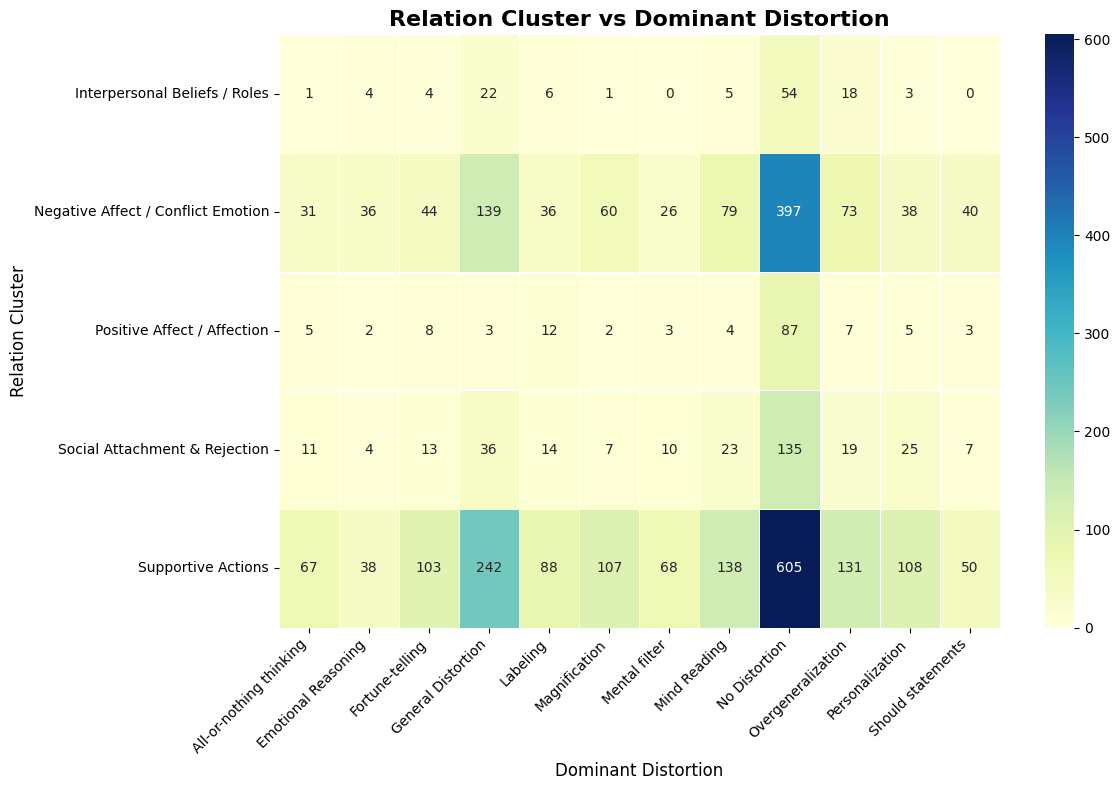

In [4]:
# Verb cluster × distortion
verb_dist_matrix = pd.crosstab(triples_df["relation_cluster_label"], triples_df["Dominant Distortion"])

plt.figure(figsize=(12, 8))  # Increased figure size
sns.heatmap(verb_dist_matrix, cmap="YlGnBu", annot=True, fmt='d', linewidths=.5) # Added linewidths
plt.title("Relation Cluster vs Dominant Distortion", fontsize=16, fontweight='bold') # Enhanced title
plt.ylabel("Relation Cluster", fontsize=12) # Enhanced y-label
plt.xlabel("Dominant Distortion", fontsize=12) # Enhanced x-label
plt.xticks(rotation=45, ha='right', fontsize=10) # Rotated and sized x-axis labels
plt.yticks(rotation=0, fontsize=10) # Sized y-axis labels
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

##  top relations and their associated distortions

In [5]:
import pandas as pd
import numpy as np
from collections import Counter

top_verbs = triples_df['relation'].value_counts().nlargest(5).index.tolist()

# 2. Create a frequency table (contingency table) of top relations and distortions
# This shows how many times each of the top 5 relations co-occurs with each distortion type.
freq_table = pd.crosstab(
    index=triples_df['relation'],
    columns=triples_df['Dominant Distortion']
)

# Filter the frequency table to include only the top 5 verbs
freq_table_top_verbs = freq_table.loc[top_verbs]

print("Frequency Table of Top 5 Verb Relations and Dominant Distortions")
display(freq_table_top_verbs)

# 3. Optional: Create binary columns for each distortion type for further analysis (e.g., correlation)
# This step is useful if you want to perform statistical tests that require binary variables.
distortion_types = triples_df['Dominant Distortion'].unique()
for dist in distortion_types:
    triples_df[f'dist_{dist}'] = (triples_df['Dominant Distortion'] == dist).astype(int)

Frequency Table of Top 5 Verb Relations and Dominant Distortions


Dominant Distortion,All-or-nothing thinking,Emotional Reasoning,Fortune-telling,General Distortion,Labeling,Magnification,Mental filter,Mind Reading,No Distortion,Overgeneralization,Personalization,Should statements
relation,,,,,,,,,,,,
love,20,7,41,60,29,32,13,35,222,53,45,11
like,14,9,10,51,22,15,15,28,117,33,8,15
hate,19,5,18,57,22,27,16,28,68,22,21,2
date,10,5,4,10,5,13,8,20,138,20,6,5
help,12,10,15,22,8,23,4,15,97,13,9,8


## Visualizing Dominant Distortion for Top 5 Relations

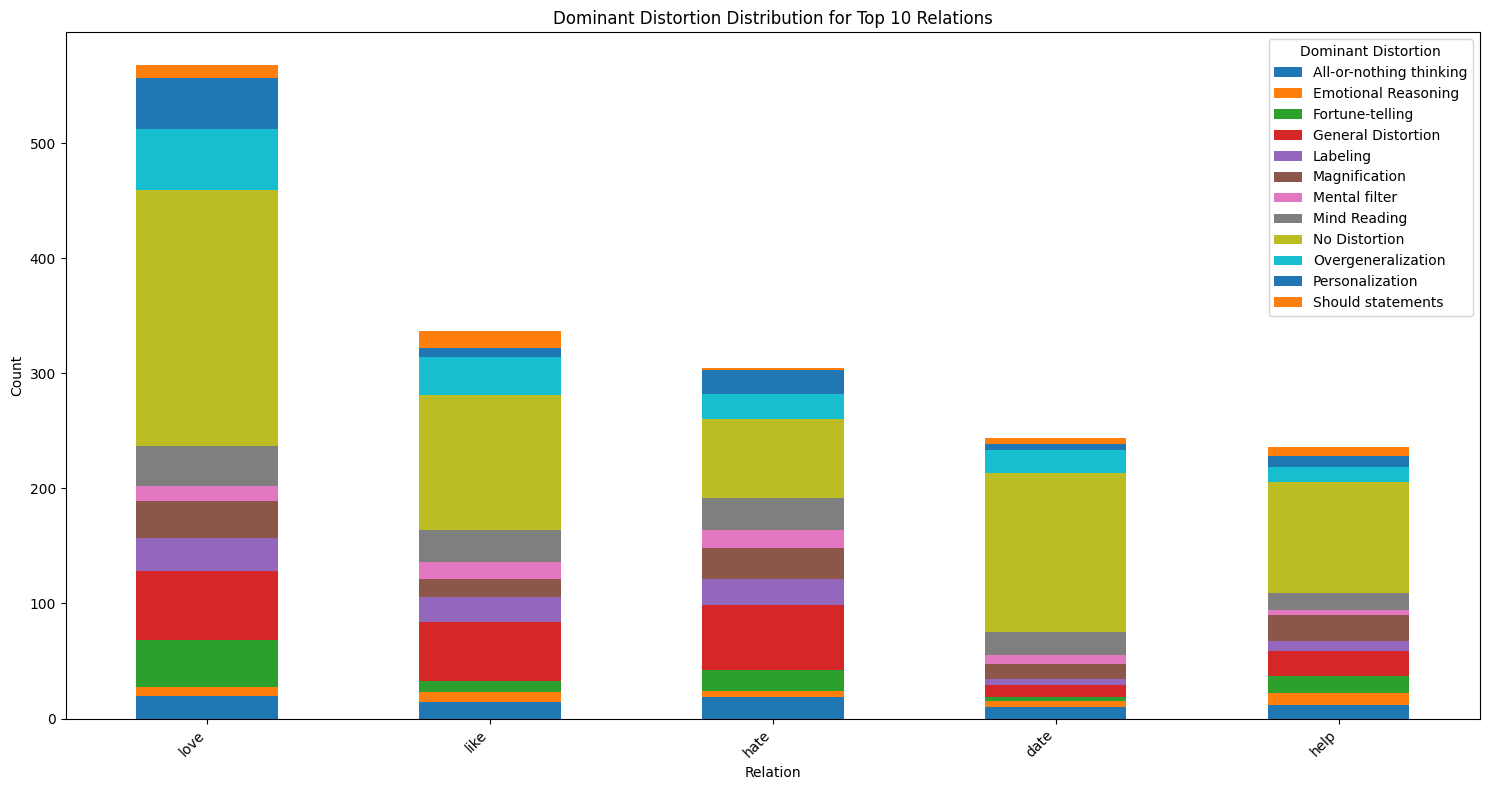

In [6]:
freq_table_top_verbs.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title("Dominant Distortion Distribution for Top 10 Relations")
plt.xlabel("Relation")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Dominant Distortion")
plt.tight_layout()
plt.show()


##

## Generating Binary Matrix of Top Relations and Distortions

In [7]:
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr

# 1. Get top 5 most frequent verb relations
top_relations = triples_df['relation'].value_counts().nlargest(5).index.tolist()

# 2. Get unique distortion types
distortion_types = triples_df['Dominant Distortion'].dropna().unique()

# 3. Create binary columns for each distortion type in a separate DataFrame
distortion_binary_df = pd.DataFrame()
for dist in distortion_types:
    distortion_binary_df[f'dist_{dist}'] = (triples_df['Dominant Distortion'] == dist).astype(int)

# 4. Generate the binary matrix by concatenating the relevant parts
binary_table = pd.concat([
    triples_df['context'],
    # One-hot encode top verbs and convert boolean to int (0 or 1)
    pd.get_dummies(triples_df['relation'])[top_relations].astype(int),
    distortion_binary_df     # Distortion flags from the new DataFrame
], axis=1)

print("Binary Matrix of Relations vs. Distortions (0s and 1s)")
display(binary_table.head())

# Note: The binary distortion columns are now in 'distortion_binary_df' and not added to 'triples_df'
# The 'binary_table' is the combined result for display and further analysis if needed as a single unit.

Binary Matrix of Relations vs. Distortions (0s and 1s)


,context,love,like,hate,date,help,dist_General Distortion,dist_No Distortion,dist_Labeling,dist_Magnification,dist_Fortune-telling,dist_Personalization,dist_Mind Reading,dist_Mental filter,dist_Emotional Reasoning,dist_Overgeneralization,dist_All-or-nothing thinking,dist_Should statements
0,Nobody likes me because I'm not interesting.,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,Nobody cares about me because they didn't ask...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,My partner didn't say 'I love you' today our ...,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,I didn't get a reply to my email they must ha...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,No one will ever love me because I'm too shy.,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [8]:
binary_table.to_csv('/content/drive/MyDrive/binary_table.csv', index=False)
print("binary_table dataframe saved successfully to Google Drive.")


binary_table dataframe saved successfully to Google Drive.


## Calculate correlations

In [9]:
corr_results = []
for rel in top_relations:
    rel_df = triples_df[triples_df['relation'] == rel]
    row = {'Relation': rel}
    for dist in distortion_types:
        try:
            corr, _ = pointbiserialr(
                (triples_df['relation'] == rel).astype(int),  # Verb presence (binary)
                triples_df[f'dist_{dist}']                    # Distortion (binary)
            )
            row[dist] = round(corr, 2)
        except:
            row[dist] = np.nan  # Handles zero-division cases
    corr_results.append(row)

corr_df = pd.DataFrame(corr_results).set_index('Relation')
print("\nCorrelation Table:")
display(corr_df)


Correlation Table:


,General Distortion,No Distortion,Labeling,Magnification,Fortune-telling,Personalization,Mind Reading,Mental filter,Emotional Reasoning,Overgeneralization,All-or-nothing thinking,Should statements
Relation,,,,,,,,,,,,
love,-0.04,0.00,0.01,0.01,0.04,0.05,-0.02,-0.02,-0.04,0.03,0.00,-0.03
like,0.02,-0.03,0.03,-0.01,-0.03,-0.05,0.01,0.02,0.00,0.03,0.01,0.03
hate,0.05,-0.11,0.04,0.05,0.01,0.02,0.02,0.04,-0.02,-0.00,0.05,-0.04
date,-0.08,0.10,-0.04,-0.00,-0.05,-0.04,0.01,0.00,-0.01,0.01,0.01,-0.02
help,-0.03,0.01,-0.02,0.05,0.01,-0.02,-0.01,-0.02,0.03,-0.02,0.02,0.01


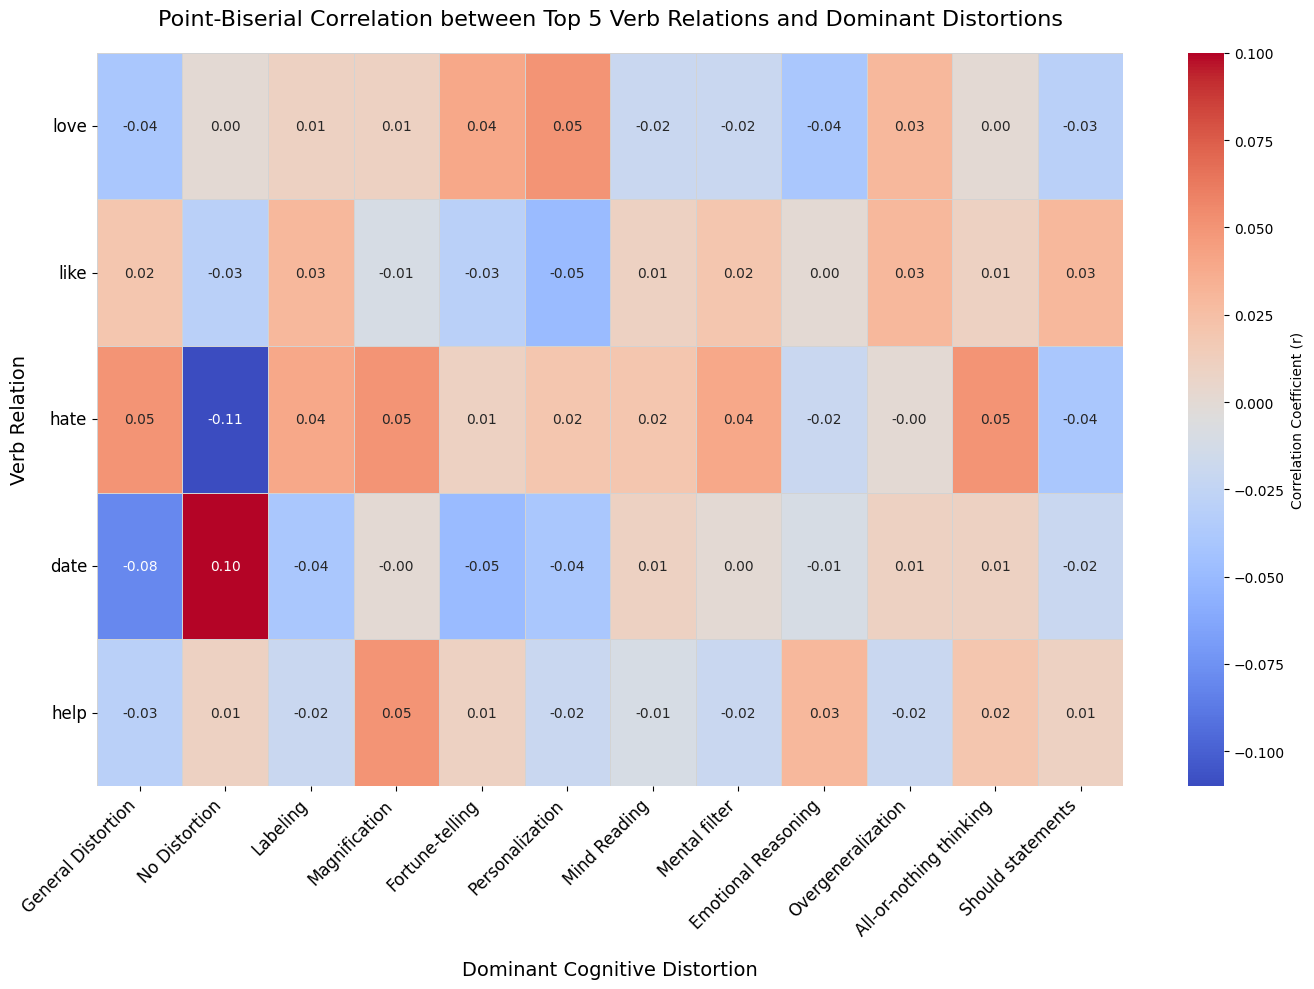

In [10]:
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_df, # Use the calculated correlation dataframe
    cmap="coolwarm", # Use a diverging colormap for correlations
    annot=True,
    fmt=".2f",
    linewidths=.5,
    linecolor='lightgray',
    cbar_kws={'label': 'Correlation Coefficient (r)'}
)
plt.title('Point-Biserial Correlation between Top 5 Verb Relations and Dominant Distortions',
          fontsize=16, pad=20)
plt.xlabel('Dominant Cognitive Distortion', fontsize=14, labelpad=15)
plt.ylabel('Verb Relation', fontsize=14, labelpad=15)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

####  Correlation Measures

## measuring agreement between your verb clusters and distortion categories (Krippendorff’s Alpha)

In [11]:
!pip install krippendorff --quiet
import krippendorff
import numpy as np
import pandas as pd

# 1. Get top 5 most frequent relations
top_5_relations = triples_df['relation'].value_counts().nlargest(5).index.tolist()

# 2. Filter dataframe for these relations
filtered_df = triples_df[triples_df['relation'].isin(top_5_relations)].copy()

# 3. Prepare Reliability Matrix
def prepare_reliability_matrix(df, items_col, categories_col):
    """Convert to items x categories matrix with counts"""
    return (
        df.groupby([items_col, categories_col])
        .size()
        .unstack(fill_value=0)
        .values
    )

try:
    # Create matrix (rows=top5_relations, columns=distortion_types)
    reliability_data = prepare_reliability_matrix(
        filtered_df,
        items_col="relation",
        categories_col="Dominant Distortion"
    )

    # Validate
    if reliability_data.shape[0] < 2 or reliability_data.shape[1] < 2:
        raise ValueError("Need ≥2 relations and ≥2 distortion types")

    # Calculate Alpha
    alpha = krippendorff.alpha(
        reliability_data=reliability_data,
        level_of_measurement='nominal'
    )

    # 4. Enhanced Output
    print("\nKrippendorff's Alpha (Top 5 Relations Only)")
    print("="*50)
    print(f"{'Top Relations:':<20} {', '.join(top_5_relations)}")
    print(f"{'Subjects:':<20} {reliability_data.shape[0]}")
    print(f"{'Distortion Types:':<20} {reliability_data.shape[1]}")
    print(f"{'Alpha Score:':<20} {alpha:.3f}")

    print("\nInterpretation:")
    print("-"*50)
    if alpha >= 0.8:
        print(" Excellent agreement")
    elif alpha >= 0.67:
        print(" Good agreement")
    elif alpha >= 0.5:
        print(" Marginal agreement")
    else:
        print(" Unacceptable agreement")

except Exception as e:
    print(f"\nError: {str(e)}")
    print("\nTry: Check if you have enough distortion types assigned to your top relations")


Krippendorff's Alpha (Top 5 Relations Only)
Top Relations:       love, like, hate, date, help
Subjects:            5
Distortion Types:    12
Alpha Score:         0.001

Interpretation:
--------------------------------------------------
 Unacceptable agreement


#### Co-occurrence Network Graph

/tmp/ipython-input-12-138322781.py:48: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


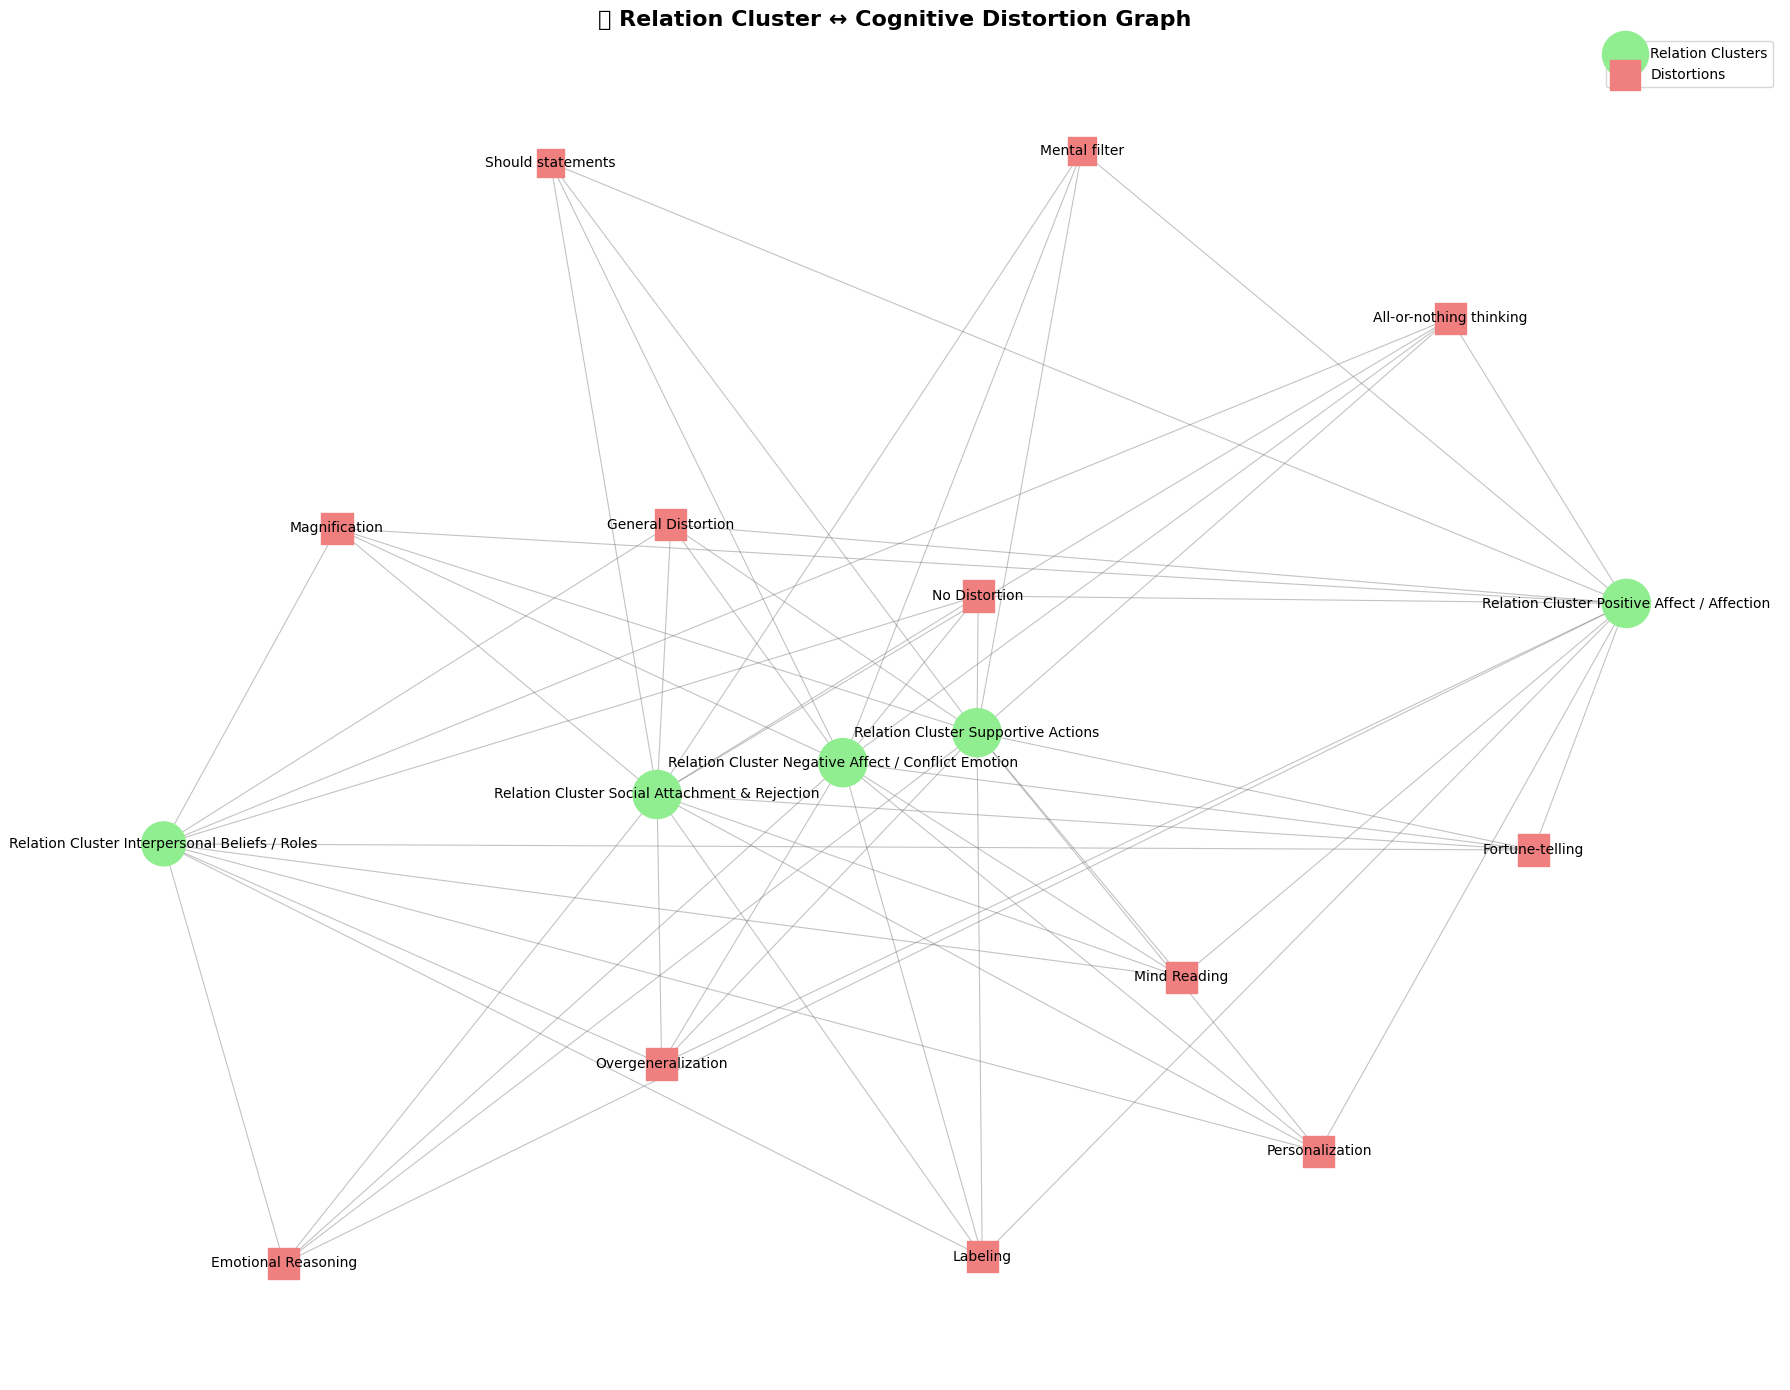

 Network Metrics:
- Nodes: 17 (Relation Clusters: 5, Distortions: 12)
- Edges: 58 unique connections
- Density: 0.426 (sparsity = 0.574)

Most connected relation clusters:
- Relation Cluster Supportive Actions: connected to 12 distortions
- Relation Cluster Negative Affect / Conflict Emotion: connected to 12 distortions
- Relation Cluster Social Attachment & Rejection: connected to 12 distortions
- Relation Cluster Positive Affect / Affection: connected to 12 distortions
- Relation Cluster Interpersonal Beliefs / Roles: connected to 10 distortions


In [12]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Count frequencies for weighted edges
edge_counts = Counter()
for _, row in triples_df.iterrows():
    verb = f"Relation Cluster {row['relation_cluster_label']}"
    dist = row["Dominant Distortion"]
    edge_counts[(verb, dist)] += 1

# Create graph and add weighted edges
G = nx.Graph()
for (verb, dist), weight in edge_counts.items():
    G.add_edge(verb, dist, weight=weight)

# Determine node types
verb_nodes = [n for n in G.nodes() if 'Relation Cluster' in n]
distortion_nodes = [n for n in G.nodes() if 'Relation Cluster' not in n]

plt.figure(figsize=(18, 14)) # Increased figure size for better readability
pos = nx.spring_layout(G, k=0.55, seed=42) # Adjusted k for better spacing

node_degrees = dict(G.degree())
verb_node_sizes = [node_degrees[node] * 100 for node in verb_nodes]
distortion_node_sizes = [node_degrees[node] * 100 for node in distortion_nodes]

# Draw nodes with different colors, shapes, and sizes
nx.draw_networkx_nodes(G, pos, nodelist=verb_nodes, node_color="lightgreen", node_size=verb_node_sizes, label="Relation Clusters", node_shape='o') # Circles for verb clusters
nx.draw_networkx_nodes(G, pos, nodelist=distortion_nodes, node_color="lightcoral", node_size=distortion_node_sizes, label="Distortions", node_shape='s') # Squares for distortions

# Draw edges
weights = [G[u][v]["weight"] for u, v in G.edges()]
nx.draw_networkx_edges(
    G, pos,
    width=0.8,
    edge_color="dimgray",
    alpha=0.4,
    style='solid',
)

# Add labels to nodes
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title("🔗 Relation Cluster ↔ Cognitive Distortion Graph", fontsize=16, fontweight="bold")
plt.legend(scatterpoints=1, loc="best")
plt.axis("off")
plt.tight_layout()
plt.show()

print(f" Network Metrics:")
print(f"- Nodes: {G.number_of_nodes()} (Relation Clusters: {len(verb_nodes)}, Distortions: {len(distortion_nodes)})")
print(f"- Edges: {G.number_of_edges()} unique connections")
print(f"- Density: {nx.density(G):.3f} (sparsity = {1 - nx.density(G):.3f})")
print("\nMost connected relation clusters:")
for node, degree in sorted(G.degree(), key=lambda x: x[1], reverse=True):
    if 'Relation Cluster' in node:
        print(f"- {node}: connected to {degree} distortions")